# Prediction: Baseball Player Salaries via Random Forest

# Business Problem

In this section, we are planning to predict the salaries of the baseball players

# Dataset Story

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

Format
* A data frame with 322 observations of major league players on the following 20 variables.
* AtBat Number of times at bat in 1986
* Hits Number of hits in 1986
* HmRun Number of home runs in 1986
* Runs Number of runs in 1986
* RBI Number of runs batted in in 1986
* Walks Number of walks in 1986
* Years Number of years in the major leagues
* CAtBat Number of times at bat during his career
* CHits Number of hits during his career
* CHmRun Number of home runs during his career
* CRuns Number of runs during his career
* CRBI Number of runs batted in during his career
* CWalks Number of walks during his career
* League A factor with levels A and N indicating player’s league at the end of 1986
* Division A factor with levels E and W indicating player’s division at the end of 1986
* PutOuts Number of put outs in 1986
* Assists Number of assists in 1986
* Errors Number of errors in 1986
* Salary 1987 annual salary on opening day in thousands of dollars
NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [2]:
hitters =pd.read_csv("/kaggle/input/hitters/Hitters.csv")
df = hitters.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5000,N


# General Information About the Dataset

In [3]:
def check_df(dataframe, head=5, tail=5):
  print('#'*20, 'HEAD', '#'*20)
  print(dataframe.head(head))
  print('#'*20, 'TAIL', '#'*20)
  print(dataframe.tail(tail))
  print('#'*20, 'SHAPE', '#'*20)
  print(dataframe.shape)
  print('#'*20, 'TYPES', '#'*20)
  print(dataframe.dtypes)
  print('#'*20, 'SIZE', '#'*20)
  print(dataframe.size)
  print('#'*20, 'NA', '#'*20)
  print(dataframe.isnull().sum())
  print('#'*20, 'QUARTILES', '#'*20)
  print(dataframe.describe([0, 0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

#################### HEAD ####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors   Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20      NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.0000         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14 480.0000         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3 500.0000         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4  91.5000         N
#################### TAIL ###############

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ['category', 'object', 'bool']]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ['uint8', 'int64', 'int32', 'float64']]
  cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and str(df[col].dtypes) in ['object', 'category']]
  cat_cols = cat_cols + num_but_cat
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['uint8', 'int64', 'float64']]
  num_cols = [col for col in num_cols if col not in cat_cols]
  return cat_cols, num_cols, cat_but_car, num_but_cat

grab_col_names(hitters)


(['League', 'Division', 'NewLeague'],
 ['AtBat',
  'Hits',
  'HmRun',
  'Runs',
  'RBI',
  'Walks',
  'Years',
  'CAtBat',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'PutOuts',
  'Assists',
  'Errors',
  'Salary'],
 [],
 [])

In [6]:
def cat_summary(dataframe, col_name, plot=False):
  print(f'############### {col_name} ###############')
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ratio': 100 * df[col_name].value_counts() / len(dataframe)}))
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show(block=True)



In [7]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in cat_cols:
    if dataframe[col].dtypes == 'bool':
      new_df = pd.DataFrame()
      new_df[col] = dataframe[col].astype(int)
      cat_summary(new_df, col, plot=True)
    else:
      cat_summary(dataframe, col, plot=True)

############### League ###############
        League   Ratio
League                
A          175 54.3478
N          147 45.6522


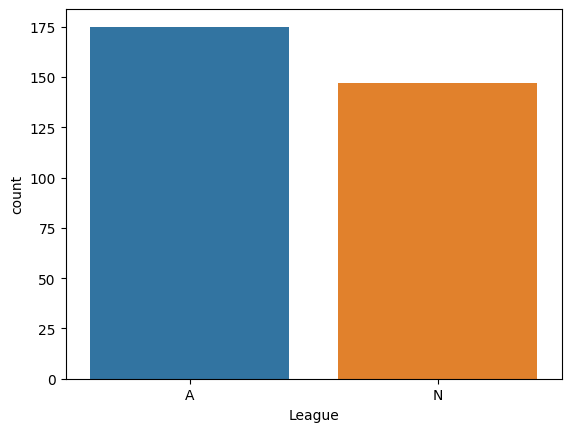

############### Division ###############
          Division   Ratio
Division                  
W              165 51.2422
E              157 48.7578


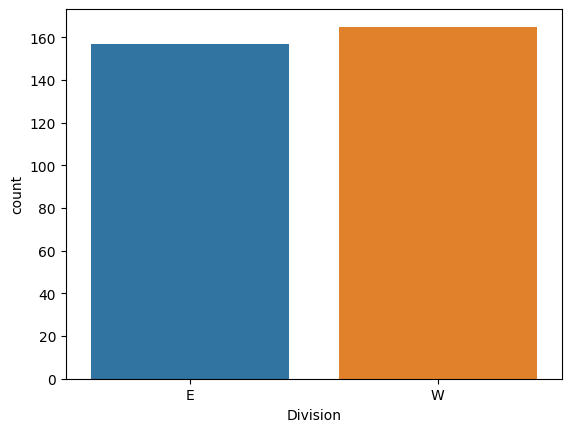

############### NewLeague ###############
           NewLeague   Ratio
NewLeague                   
A                176 54.6584
N                146 45.3416


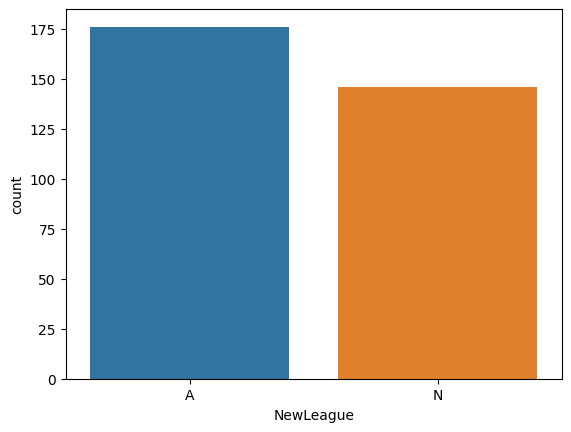

In [8]:
cat_summary_df(df)

In [9]:
def num_summary(dataframe, num_col, plot=False):
  print(f'############### {num_col} ###############')
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.ylabel(num_col)
    plt.show(block=True)

In [10]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

############### AtBat ###############
count   322.0000
mean    380.9286
std     153.4050
min      16.0000
1%       20.4200
5%      161.0000
10%     194.1000
20%     221.8000
30%     281.3000
40%     321.8000
50%     379.5000
60%     430.2000
70%     490.0000
80%     535.6000
90%     584.9000
95%     609.9000
99%     658.5900
max     687.0000
Name: AtBat, dtype: float64


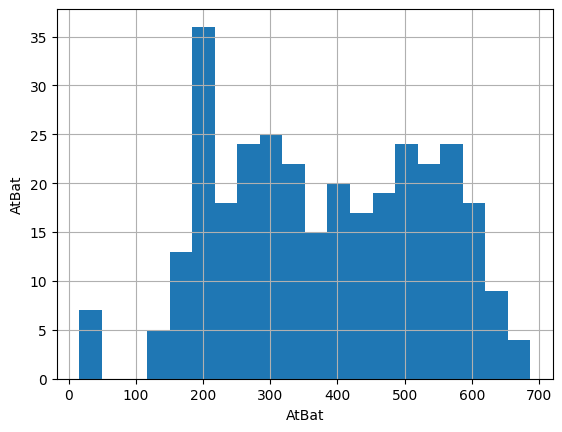

############### Hits ###############
count   322.0000
mean    101.0248
std      46.4547
min       1.0000
1%        4.4200
5%       39.0000
10%      45.1000
20%      57.0000
30%      70.0000
40%      82.0000
50%      96.0000
60%     113.0000
70%     128.7000
80%     144.0000
90%     163.0000
95%     174.0000
99%     210.7900
max     238.0000
Name: Hits, dtype: float64


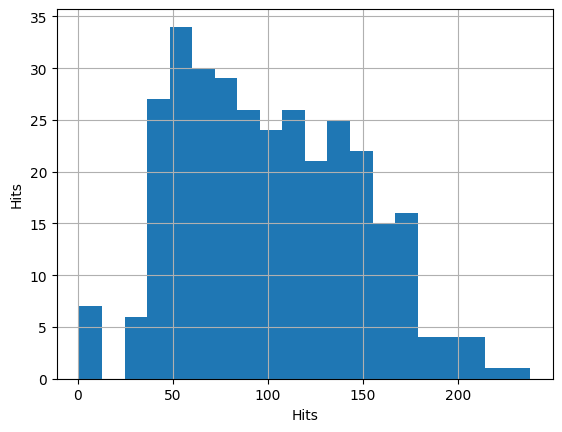

############### HmRun ###############
count   322.0000
mean     10.7702
std       8.7090
min       0.0000
1%        0.0000
5%        0.0000
10%       1.0000
20%       3.0000
30%       5.0000
40%       6.0000
50%       8.0000
60%      10.6000
70%      14.0000
80%      18.0000
90%      24.0000
95%      28.9500
99%      33.0000
max      40.0000
Name: HmRun, dtype: float64


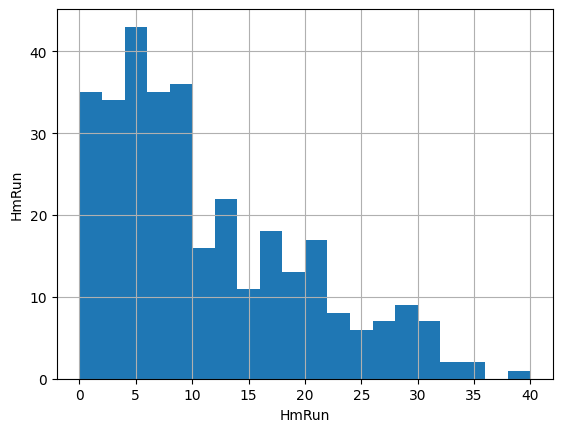

############### Runs ###############
count   322.0000
mean     50.9099
std      26.0241
min       0.0000
1%        1.2100
5%       17.0000
10%      20.1000
20%      27.0000
30%      33.0000
40%      41.0000
50%      48.0000
60%      55.6000
70%      66.0000
80%      75.8000
90%      89.0000
95%      94.0000
99%     107.7900
max     130.0000
Name: Runs, dtype: float64


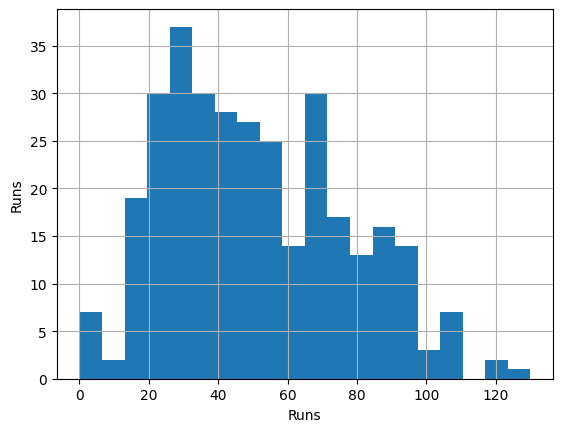

############### RBI ###############
count   322.0000
mean     48.0280
std      26.1669
min       0.0000
1%        2.0000
5%       14.0000
10%      19.0000
20%      26.0000
30%      30.0000
40%      36.4000
50%      44.0000
60%      49.0000
70%      58.0000
80%      73.0000
90%      86.0000
95%      96.0000
99%     112.3700
max     121.0000
Name: RBI, dtype: float64


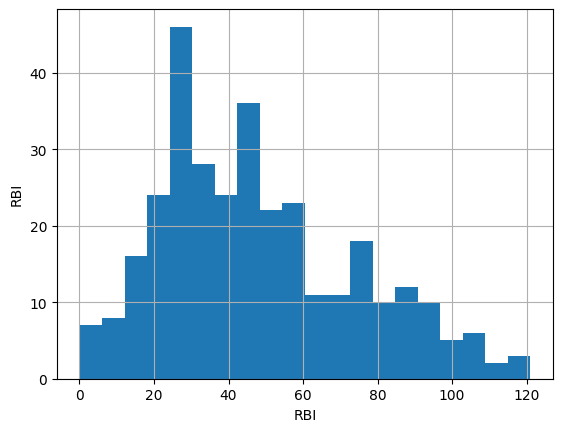

############### Walks ###############
count   322.0000
mean     38.7422
std      21.6393
min       0.0000
1%        1.0000
5%       11.0500
10%      15.0000
20%      20.0000
30%      24.0000
40%      30.0000
50%      35.0000
60%      40.0000
70%      48.7000
80%      59.0000
90%      69.9000
95%      78.0000
99%      93.5800
max     105.0000
Name: Walks, dtype: float64


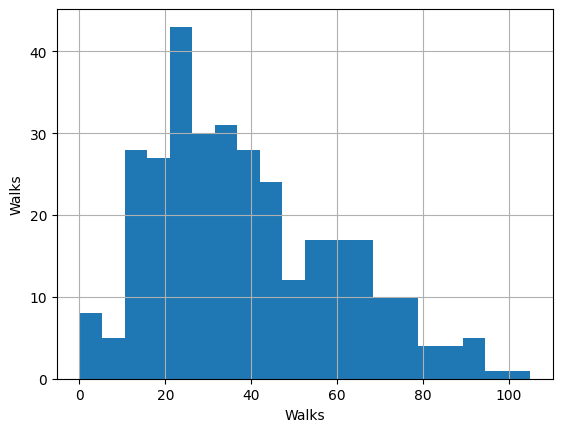

############### Years ###############
count   322.0000
mean      7.4441
std       4.9261
min       1.0000
1%        1.0000
5%        1.0000
10%       2.0000
20%       3.0000
30%       4.0000
40%       5.0000
50%       6.0000
60%       7.6000
70%      10.0000
80%      12.0000
90%      15.0000
95%      17.0000
99%      19.7900
max      24.0000
Name: Years, dtype: float64


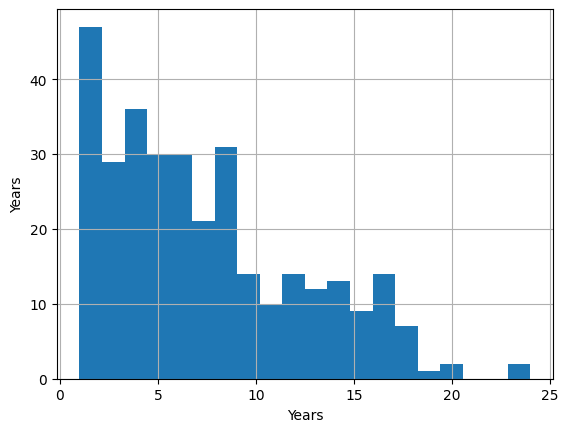

############### CAtBat ###############
count     322.0000
mean     2648.6832
std      2324.2059
min        19.0000
1%         41.0000
5%        216.5000
10%       342.2000
20%       667.6000
30%       963.4000
40%      1402.2000
50%      1928.0000
60%      2654.0000
70%      3365.0000
80%      4483.0000
90%      6123.4000
95%      7125.6000
99%      8749.9700
max     14053.0000
Name: CAtBat, dtype: float64


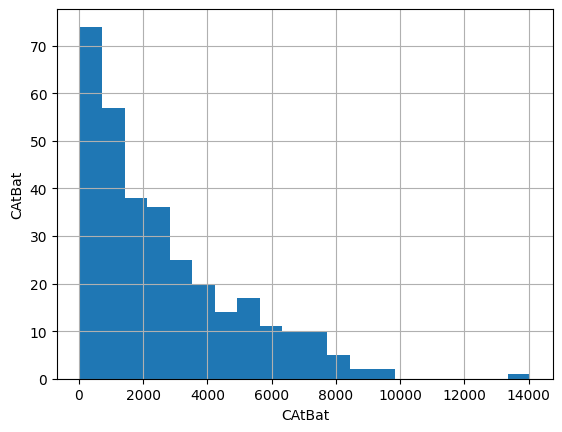

############### CHits ###############
count    322.0000
mean     717.5714
std      654.4726
min        4.0000
1%         9.8400
5%        54.0000
10%       86.0000
20%      164.6000
30%      238.0000
40%      355.8000
50%      508.0000
60%      708.2000
70%      911.1000
80%     1229.2000
90%     1659.6000
95%     2017.1500
99%     2500.3400
max     4256.0000
Name: CHits, dtype: float64


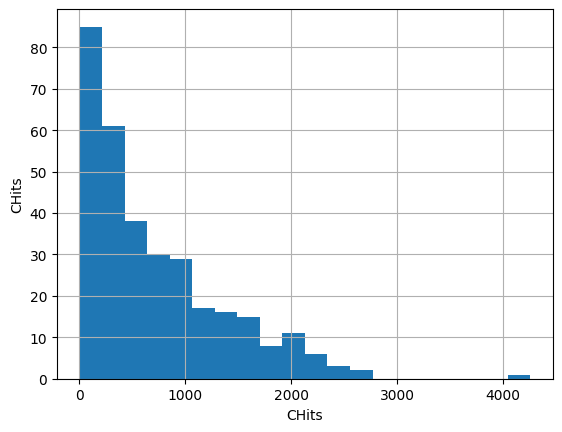

############### CHmRun ###############
count   322.0000
mean     69.4907
std      86.2661
min       0.0000
1%        0.0000
5%        2.0000
10%       4.0000
20%      10.2000
30%      16.3000
40%      27.4000
50%      37.5000
60%      51.2000
70%      72.4000
80%     103.8000
90%     194.9000
95%     265.6500
99%     373.1200
max     548.0000
Name: CHmRun, dtype: float64


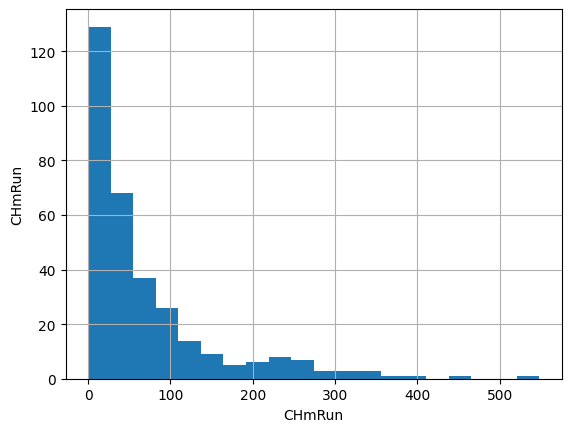

############### CRuns ###############
count    322.0000
mean     358.7950
std      334.1059
min        1.0000
1%         3.6300
5%        27.0000
10%       38.1000
20%       80.4000
30%      117.3000
40%      181.0000
50%      247.0000
60%      333.0000
70%      443.4000
80%      627.2000
90%      895.7000
95%     1032.3000
99%     1174.3700
max     2165.0000
Name: CRuns, dtype: float64


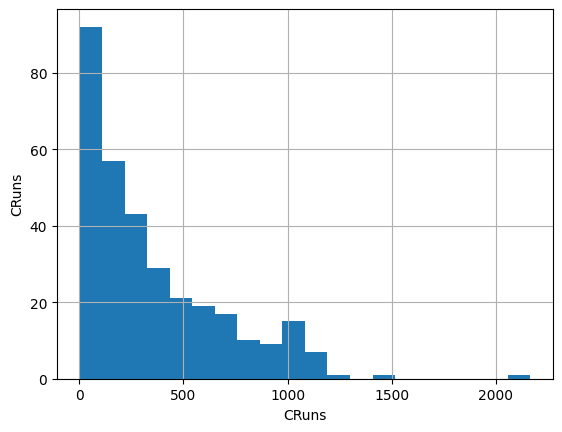

############### CRBI ###############
count    322.0000
mean     330.1180
std      333.2196
min        0.0000
1%         4.6300
5%        22.0500
10%       34.1000
20%       70.2000
30%      106.3000
40%      149.0000
50%      220.5000
60%      303.6000
70%      379.1000
80%      496.2000
90%      861.6000
95%     1071.7500
99%     1310.8500
max     1659.0000
Name: CRBI, dtype: float64


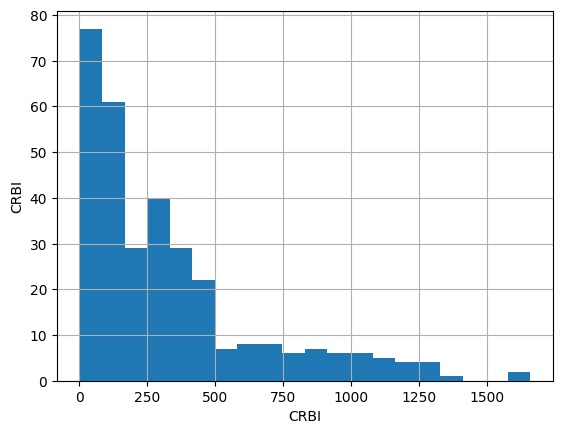

############### CWalks ###############
count    322.0000
mean     260.2391
std      267.0581
min        0.0000
1%         4.0000
5%        15.0500
10%       30.1000
20%       55.0000
30%       82.0000
40%      117.4000
50%      170.5000
60%      226.6000
70%      300.7000
80%      421.0000
90%      643.9000
95%      817.6000
99%     1139.1400
max     1566.0000
Name: CWalks, dtype: float64


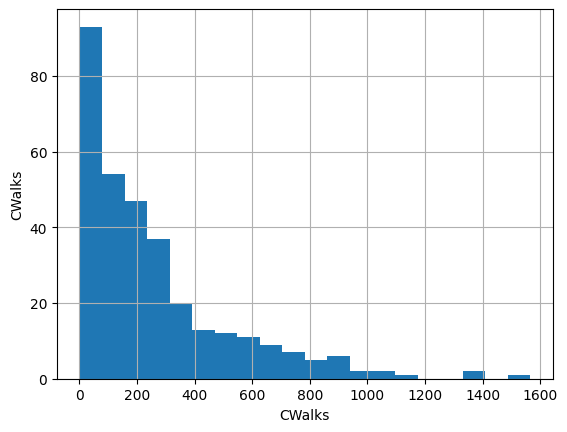

############### PutOuts ###############
count    322.0000
mean     288.9379
std      280.7046
min        0.0000
1%         0.0000
5%        33.2000
10%       62.2000
20%       99.6000
30%      132.0000
40%      167.0000
50%      212.0000
60%      257.4000
70%      303.0000
80%      365.8000
90%      685.6000
95%      910.6500
99%     1301.1900
max     1378.0000
Name: PutOuts, dtype: float64


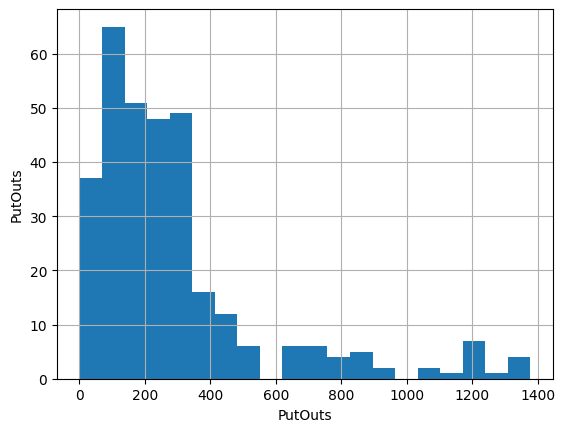

############### Assists ###############
count   322.0000
mean    106.9130
std     136.8549
min       0.0000
1%        0.0000
5%        0.0000
10%       2.0000
20%       5.2000
30%       9.0000
40%      15.4000
50%      39.5000
60%      76.8000
70%     134.8000
80%     210.8000
90%     353.3000
95%     431.4500
99%     478.1600
max     492.0000
Name: Assists, dtype: float64


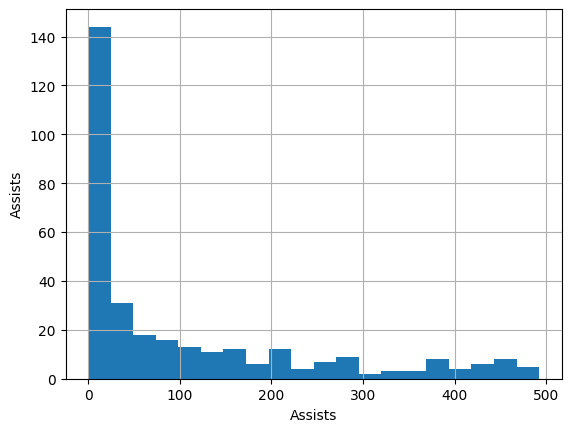

############### Errors ###############
count   322.0000
mean      8.0404
std       6.3684
min       0.0000
1%        0.0000
5%        0.0000
10%       1.0000
20%       3.0000
30%       4.0000
40%       5.0000
50%       6.0000
60%       8.0000
70%      10.0000
80%      13.0000
90%      17.0000
95%      20.0000
99%      25.7900
max      32.0000
Name: Errors, dtype: float64


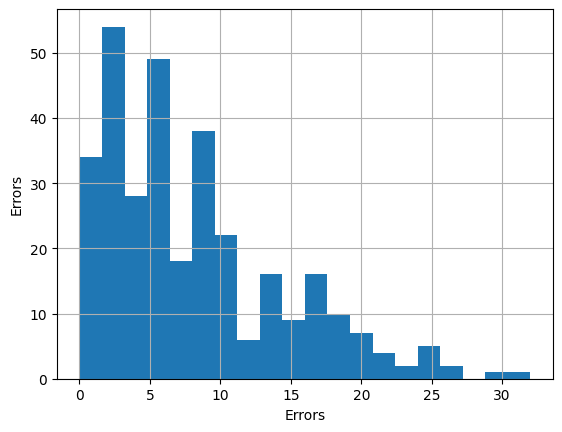

############### Salary ###############
count    263.0000
mean     535.9259
std      451.1187
min       67.5000
1%        70.0000
5%        86.6000
10%      100.0000
20%      155.0000
30%      221.0000
40%      300.0000
50%      425.0000
60%      538.0000
70%      700.0000
80%      809.0000
90%     1048.6666
95%     1346.0000
99%     2032.8865
max     2460.0000
Name: Salary, dtype: float64


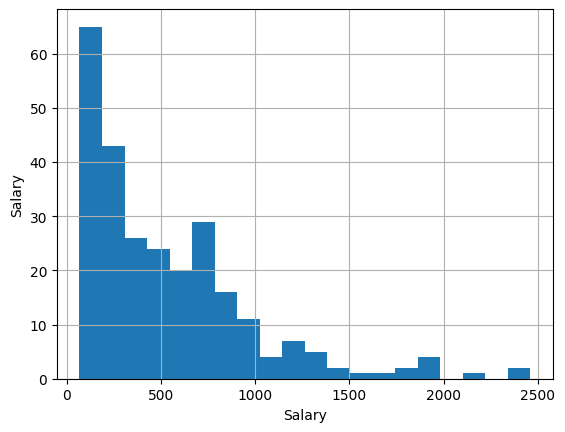

In [11]:
num_summary_df(df)

In [12]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(12, 4))
  for index, col in enumerate(num_cols):
    plt.subplot(3, 6, index+1)
    plt.tight_layout()
    df[col].hist(bins=20)
    plt.title(col)

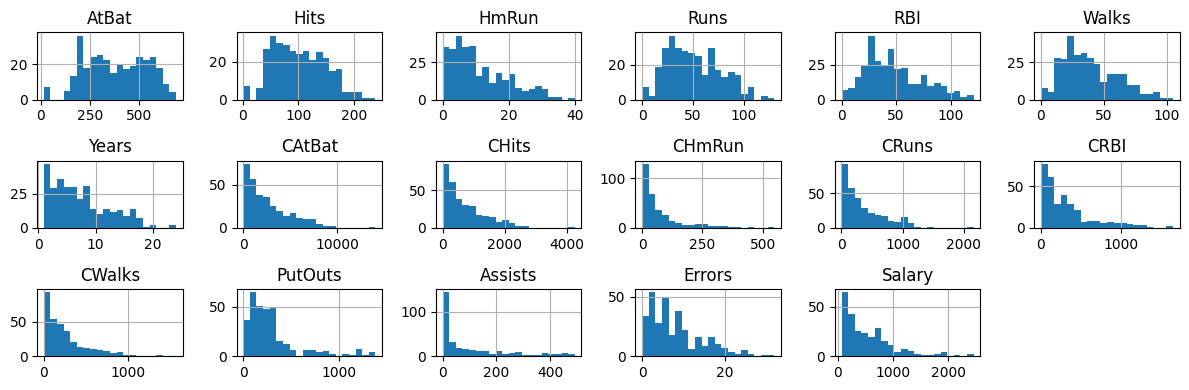

In [13]:
plot_num_summary(df)

# Target Analysis

In [14]:
def target_summary_with_cat(dataframe, target, categorical_col):
  print(f'################ {target} --> {categorical_col} #################')
  print(pd.DataFrame({'Target Mean': dataframe.groupby(categorical_col)[target].mean()}))

In [15]:
def target_summary_with_cat_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in cat_cols:
    target_summary_with_cat(dataframe, target, col)


In [16]:
target_summary_with_cat_df(df, "Salary")

################ Salary --> League #################
        Target Mean
League             
A          541.9995
N          529.1175
################ Salary --> Division #################
          Target Mean
Division             
E            624.2714
W            450.8769
################ Salary --> NewLeague #################
           Target Mean
NewLeague             
A             537.1130
N             534.5539


# Correlation Analysis

In [17]:
def correlated_cols(dataframe):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['uint8', 'int64', 'float64']]
  corr = dataframe[num_cols].corr()
  sns.set(rc={'figure.figsize':(18, 10)})
  sns.heatmap(corr, cmap='RdBu', annot=True, fmt='.2f')
  plt.show()


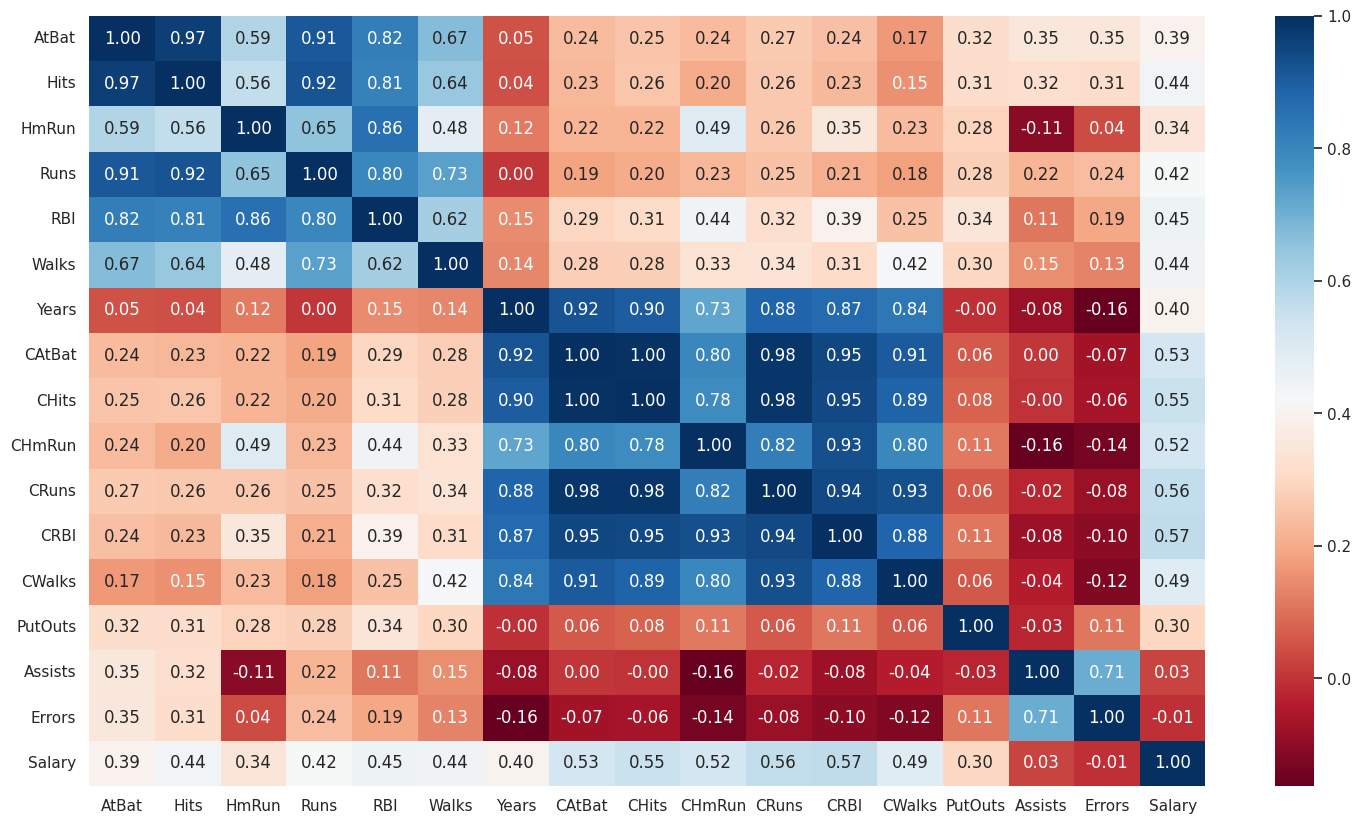

In [18]:
correlated_cols(df)

In [19]:
def high_correlated_cols(dataframe, corr_th=0.90, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['uint8', 'int64', 'float64']]
  corr = dataframe[num_cols].corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangle_matrix if any(upper_triangle_matrix[col] > corr_th)]
  if drop_list == 0:
    print('############### After Correlation Analysis, You Do not neead to remove variables #############')
  if plot:
      sns.set(rc={'figure.figsize':(18, 10)})
      sns.heatmap(corr, cmap='RdBu', annot=True, fmt='.2f')
      plt.show()

  return drop_list

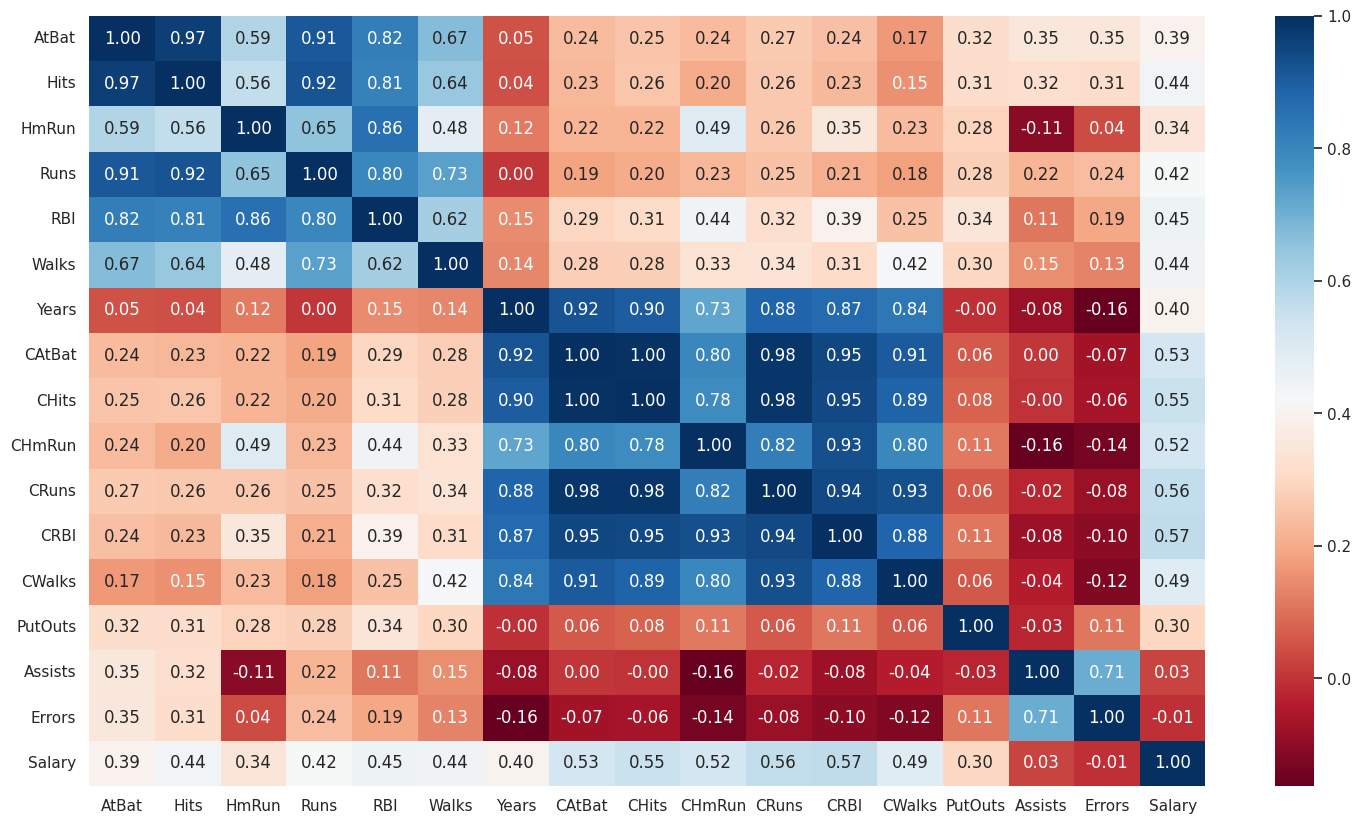

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [20]:
high_correlated_cols(df, plot=True)

# Missing Value Analysis

In [21]:
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [22]:
na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
na_columns

['Salary']

In [23]:
n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
print(missing_df)

        n_miss   ratio
Salary      59 18.3200


In [24]:
def missing_values_table(dataframe):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

In [25]:
missing_values_table(df)

        n_miss   ratio
Salary      59 18.3200


In [26]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [27]:
df = fill_na_with_median(df)

In [28]:
df.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,425.0000,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5000,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0000,A
6,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.0000,A
7,298,73,0,24,24,7,3,509,108,0,41,37,12,A,W,121,283,9,100.0000,A
8,323,81,6,26,32,8,2,341,86,6,32,34,8,N,W,143,290,19,75.0000,N
9,401,92,17,49,66,65,13,5206,1332,253,784,890,866,A,E,0,0,0,1100.0000,A


# Encoding

In [29]:
def one_hot_encoding(dataframe, drop_first=True):
  cat_cols, num_cols, cat_but_car, numt_but_car = grab_col_names(df)
  dataframe = pd.get_dummies(df, columns=cat_cols, drop_first=drop_first)
  return dataframe

In [30]:
cat_cols, num_cols, cat_but_car, numt_but_car = grab_col_names(df)
test = pd.get_dummies(df, columns=cat_cols, drop_first=True)
test.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,425.0000,False,False,False
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0000,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0000,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0000,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5000,True,False,True


In [31]:
df = one_hot_encoding(df)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,425.0000,False,False,False
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0000,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0000,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0000,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5000,True,False,True


# Random Forest: Machine Learning Algorithm

In [32]:
def RF_Model(dataframe, target, test_size=0.20, results=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
  if results:
    mse_train = np.sqrt(mean_squared_error(y_train, rf_model.predict(X_train)))
    mse_test = np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test)))
    rmse_train = mean_absolute_error(y_train, rf_model.predict(X_train))
    rmse_test = mean_absolute_error(y_test, rf_model.predict(X_test))
    r2_train = r2_score(y_train, rf_model.predict(X_train))
    r2_test = r2_score(y_test, rf_model.predict(X_test))
    cv_results_mse = cross_validate(rf_model, X, y, cv=5, scoring="neg_mean_squared_error")
    cv_results_rmse = cross_validate(rf_model, X, y, cv=5, scoring="neg_root_mean_squared_error")
    print(20*"*", "RF Model Results", 20*"*")
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validate MSE Score:", "%.3f" % -cv_results_mse["test_score"].mean())
    print("Cross Validate RMSE Score:", "%.3f" % -cv_results_rmse["test_score"].mean())

  if plot_importance:
    feature_imp = pd.DataFrame({"Value": rf_model.feature_importances_, "Feature":X.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

  if save_model:
    joblib.dump(rf_model, "rf_model.pkl")

  return rf_model


******************** RF Model Results ********************
MSE Train:  110.665
MSE Test:  292.432
RMSE Train:  70.707
RMSE Test:  194.495
R2 Train:  0.924
R2 Test:  0.555
Cross Validate MSE Score: 87996.550
Cross Validate RMSE Score: 291.386


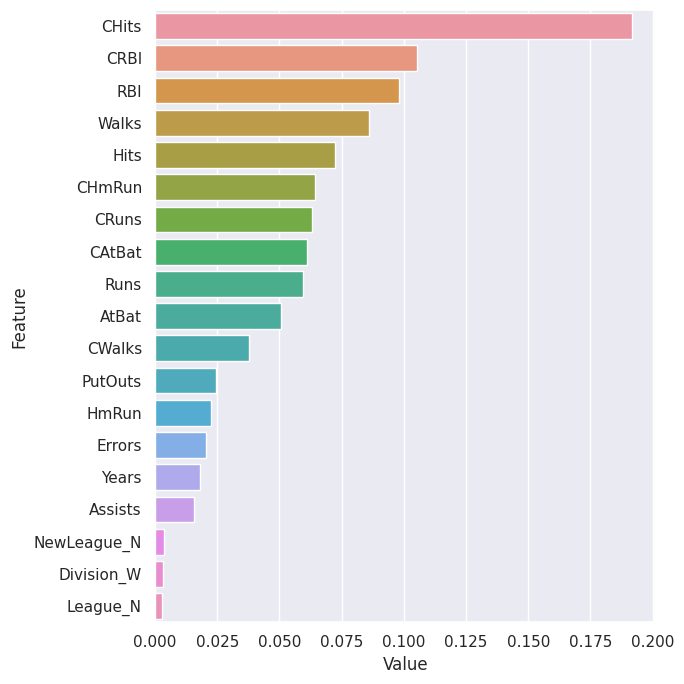

In [33]:
rf_model = RF_Model(df, "Salary", results=True, plot_importance=True, save_model=True)

# Loading a Base Model and Prediction

In [34]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [35]:
model_disc = load_model("rf_model.pkl")

In [36]:
X = df.drop("Salary", axis=1)
x = X.sample(1).values.tolist()

In [37]:
model_disc.predict(pd.DataFrame(X))[0]

331.68

In [38]:
sample2 = [250, 70, 15, 40, 100, 30, 8, 1800, 500, 80, 220, 290, 140, 700, 90, 8, False, True, True]

In [39]:
model_disc.predict(pd.DataFrame(sample2).T)[0]

620.0307300000001

# Model Tuning

In [52]:
def RF_Model_Tuned(dataframe, target, test_size=0.20, results=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  rf_model = RandomForestRegressor(random_state=42)
  rf_params = {
    "max_depth": list(range(1, 6)),
    "max_features": [3, 5, 8],
    "n_estimators": [100, 200, 500]
  }

  rf_cv_model = GridSearchCV(rf_model, rf_params, cv=5, verbose=True, n_jobs=-1).fit(X_train, y_train)
  rf_model_tuned = rf_model.set_params(**rf_cv_model.best_params_, random_state=42).fit(X, y)

  if results:
    mse_train = np.sqrt(mean_squared_error(y_train, rf_model_tuned.predict(X_train)))
    mse_test = np.sqrt(mean_squared_error(y_test, rf_model_tuned.predict(X_test)))
    rmse_train = mean_absolute_error(y_train, rf_model_tuned.predict(X_train))
    rmse_test = mean_absolute_error(y_test, rf_model_tuned.predict(X_test))
    r2_train = r2_score(y_train, rf_model_tuned.predict(X_train))
    r2_test = r2_score(y_test, rf_model_tuned.predict(X_test))
    cv_results_mse = cross_validate(rf_model_tuned, X, y, cv=5, scoring="neg_mean_squared_error")
    cv_results_rmse = cross_validate(rf_model_tuned, X, y, cv=5, scoring="neg_root_mean_squared_error")
    print(20*"*", "RF Model Results", 20*"*")
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validate MSE Score:", "%.3f" % -cv_results_mse["test_score"].mean())
    print("Cross Validate RMSE Score:", "%.3f" % -cv_results_rmse["test_score"].mean())

  if plot_importance:
    feature_imp = pd.DataFrame({"Value": rf_model_tuned.feature_importances_, "Feature":X.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

  if save_model:
    joblib.dump(rf_model_tuned, "rf_model_tuned.pkl")

  return rf_model_tuned


Fitting 5 folds for each of 45 candidates, totalling 225 fits
******************** RF Model Results ********************
MSE Train:  195.900
MSE Test:  210.187
RMSE Train:  140.532
RMSE Test:  145.399
R2 Train:  0.761
R2 Test:  0.770
Cross Validate MSE Score: 84230.838
Cross Validate RMSE Score: 285.428


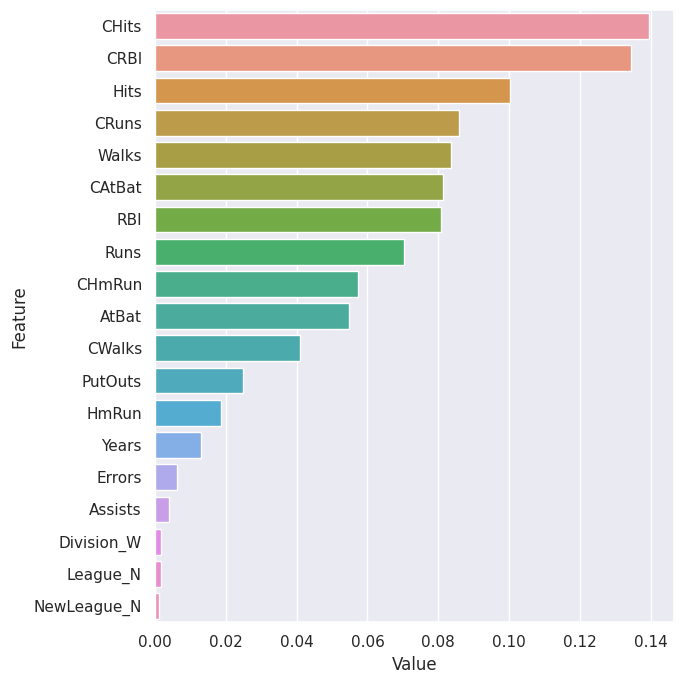

In [53]:
rf_model_tuned = RF_Model_Tuned(df, "Salary", results=True, plot_importance=True, save_model=True)

# Loading a Tuned Model and Prediction

In [54]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [55]:
model_disc = load_model("rf_model_tuned.pkl")

In [56]:
X = df.drop("Salary", axis=1)
x = X.sample(1).values.tolist()

In [57]:
model_disc.predict(pd.DataFrame(X))[0]

186.33951137202502

In [58]:
sample2 = [250, 70, 15, 40, 100, 30, 8, 1800, 500, 80, 220, 290, 140, 700, 90, 8, False, True, True]

In [59]:
model_disc.predict(pd.DataFrame(sample2).T)[0]

560.5904032788515